<a href="https://colab.research.google.com/github/Akhil-CS/RecommenderSystem/blob/master/ML1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr
import random

In [0]:
ratings = pd.read_csv("/content/drive/My Drive/colab/movielens/ratings.csv")
ratings = ratings[['userId','movieId', 'rating']].copy()

In [0]:
#for all the movies taking the ratings of all users to that movie
#finding the average rating to that movie
#finding the k top rated movies
def top_k_movies_not_rated_by_target(k,target_user):
  df_for_avg_k_movies = pd.DataFrame(columns=["movieId", "rating"])
 
  movie_not_rated_by_target = ratings.loc[ratings['userId'] != target_user]
  movie_not_rated_by_target = movie_not_rated_by_target[['movieId', 'rating']].copy()
  
  not_rated_movies_by_target = set(list(movie_not_rated_by_target[['movieId']].values.flatten()))
  
  for movie in not_rated_movies_by_target:
    fetch_movie_rows = movie_not_rated_by_target.loc[movie_not_rated_by_target['movieId'] == movie]
    fetch_ratings_for_movie = fetch_movie_rows[['rating']].values.flatten()
    avg_rating_for_movie = np.divide(np.sum(fetch_ratings_for_movie, axis=0),len(fetch_ratings_for_movie))
    df_for_avg_k_movies = df_for_avg_k_movies.append({ "movieId": movie, "rating": avg_rating_for_movie}, ignore_index=True) 
  
  df_for_avg_k_movies.sort_values('rating')
  
  return df_for_avg_k_movies.head(k)


def find_movie_not_rated(target_user, ratings):
  #movie_not_rated_by_target = ratings.loc[ratings['userId'] != target_user]
  #movie_not_rated_by_target = movie_not_rated_by_target[['movieId', 'rating']].copy()  
  k_movies_not_rated_by_target = 100
  top_K_movies_not_rated_by_target = top_k_movies_not_rated_by_target(k_movies_not_rated_by_target, target_user)
  return top_K_movies_not_rated_by_target

def find_movie_rated(target_user, ratings):
  movie_rated_by_target = ratings.loc[ratings['userId'] == target_user]
  movie_rated_by_target = movie_rated_by_target[['movieId', 'rating']].copy()
  return movie_rated_by_target

def find_pearson_coeff_list(ratings, all_users_minus_target_user, arr_movies, arr_rating):
  pearson = []
  for user in all_users_minus_target_user:
  
    rated_movies_by_user = ratings.loc[ratings['userId'] == user].copy()

    #rated_movies_by_user = list(rated_movies_by_user[['movieId']].values.flatten())
    rating_by_user = []
    for movie in arr_movies:
      find_movie = rated_movies_by_user.loc[rated_movies_by_user['movieId'] == movie]
      get_rating_on_movie = list(find_movie[['rating']].values.flatten())

      #conditions to see whether a user has rated the movie or not

      if get_rating_on_movie != []:
        rating_by_user.append(get_rating_on_movie[0])
      else:
        rating_by_user.append(-1)


    p_corr,p_value = pearsonr(arr_rating, rating_by_user)

    #check if a number is nan or not --> if yes--> add -5000 to the list

    if np.isnan(p_corr):
      pearson.append(-500)
    else:
      pearson.append(p_corr)
  
  return pearson

#getting the index of the top k users which are similar to the given user for K-NN
def find_k_max(k, list_coeff):
  max_k_users = sorted(range(len(list_coeff)), key=lambda i: list_coeff[i])[-k:]
  return max_k_users

def movies_rated_by_similar_users_which_target_hasnot_rated(ratings, max_k_users, all_users_minus_target_user, arr_movies):
  #taking ids of all the similar users
  similar_user_ids = []

  #taking all the movies rated by similar user to suggest to the target user
  
  similar_user_rated_movies = []
  for user in max_k_users:
    similar_user_ids.append(all_users_minus_target_user[user])
  #  user_rows = ratings.loc[ratings['userId'] == all_users_minus_target_user[user]]
   # similar_user_rated_movies.extend(user_rows[['movieId']].values.flatten())


  #From the movies which similar users has rated, removing the movies which target user has already seen
  #similar_user_rated_movies = set(similar_user_rated_movies)-set(arr_movies)
 # return similar_user_rated_movies, similar_user_ids
  return similar_user_ids


def calculate_target_rating_on_unrated_movies(ratings, similar_user_ids, similar_user_rated_movies, max_k_users, target_user_avg_rating, list_coeff):
  
  # new dataframe for storing the movieId and predicted rating by the target user on unrated movies
  df_for_predicted = pd.DataFrame(columns=["movieId", "predictedRating"])

  #From 'movie_not_rated_by_target' taking the movie ids not rated by target user 
  #movies_ids_not_rated_by_target = set(list(movie_not_rated_by_target[["movieId"]].values.flatten()))
  #finding rating for each movie not rated by the target

  #movie_not_rated_by_target = movie_not_rated_by_target['movieId'].copy()

  # 'movie_not_rated_by_target' will give an error here, instead uss 'similar_user_rated_movies'
  for movie in similar_user_rated_movies:
    i=0
    total_sum_of_similarities_and_ratings = 0.0
    total_sum_of_similarities = 0.0
    rating_of_target_user_to_ith_movie = 0.0

    #rating given by each similar user to the kth movie  
    for eachSimilarUser in similar_user_ids:
      similar_user_rows = ratings.loc[ratings['userId'] == eachSimilarUser]
      average_rating_similar_user = np.divide(np.sum(similar_user_rows[['rating']].values.flatten(), axis=0),similar_user_rows.shape[0])

      ############ handle the case here where that movie is not rated by the user coz it's taking trash value
      similar_user_rating_to_movie = similar_user_rows.loc[similar_user_rows['movieId'] == movie]
      rating_value = similar_user_rating_to_movie[['rating']].values.flatten()

      if(len(rating_value) > 0):
        pearson_coeff_user = abs(list_coeff[max_k_users[i]])
        ###### check here if list_coeff[max_k_users[i]] is equal to  -5000....don't consider it
        total_sum_of_similarities_and_ratings = total_sum_of_similarities_and_ratings + (pearson_coeff_user * (rating_value[0] - average_rating_similar_user))
        total_sum_of_similarities = total_sum_of_similarities + pearson_coeff_user
        i = i+1

    ############ handle the else case --> NO NEED  ###############################
    #print("hereeee")
    #print(target_user_avg_rating)
    
    if(total_sum_of_similarities != 0):
      rating_of_target_user_to_ith_movie = target_user_avg_rating + (total_sum_of_similarities_and_ratings/total_sum_of_similarities) 

    ############ handle the else case --> NO NEED  ###############################
      df_for_predicted = df_for_predicted.append({ "movieId": movie, "predictedRating": rating_of_target_user_to_ith_movie}, ignore_index=True)
      #print(movie)
     # print(rating_of_target_user_to_ith_movie)
      #print()
      #print(rating_of_target_user_to_ith_movie)
  return df_for_predicted



def user_user_recommendation(ratings, target_user, movie_not_rated_by_target, movie_rated_by_target, k):
  
  rated_movies_by_target = movie_rated_by_target[['movieId']]
  ratings_by_target = movie_rated_by_target[['rating']]
  
  not_rated_movies_by_target = list(set(list(movie_not_rated_by_target[['movieId']].values.flatten())))

  #converting to 1-D array of all movies rated by target user
  arr_movies = list(rated_movies_by_target.values.flatten())
  arr_rating = list(ratings_by_target.values.flatten())
  #print(list(arr_movies))

  num_movies = len(arr_movies)
  all_users_minus_target_user = list(set(all_users) - set([target_user]))
  
  #pearson = find_pearson_coeff_list(ratings, all_users_minus_target_user, arr_movies, arr_rating)
  
  # save all the correlation coeffcients into a file in drive

  '''
  f = open("/content/drive/My Drive/colab/movielens/correlation.txt", 'w')
  f.write(" ".join(str(x) for x in pearson))
  f.close()
  
  
  # get the file from the drive and read the contents

  f = open("/content/drive/My Drive/colab/movielens/correlation.txt", 'r')
  coeff = f.read().split()
  f.close()
  list_coeff = []
  for c in coeff:
    #convert to float to be used later
    list_coeff.append(float(c))
  #print(list_coeff.index(max(list_coeff)))
  '''
  pearson = find_pearson_coeff_list(ratings, all_users_minus_target_user, arr_movies, arr_rating)
  list_coeff = pearson
  
  max_k_users = find_k_max(k, list_coeff)
  #print("1")
  similar_user_ids = movies_rated_by_similar_users_which_target_hasnot_rated(ratings, max_k_users, all_users_minus_target_user, arr_movies)
  
  #avg rating by target
  target_user_avg_rating  = (np.divide(np.sum(ratings_by_target,axis = 0),len(ratings_by_target)).values.flatten())[0]
  #print("2")
  # dataframe for predicted movies using KNN
  df_for_predicted = calculate_target_rating_on_unrated_movies(ratings, similar_user_ids, not_rated_movies_by_target, max_k_users, target_user_avg_rating, list_coeff)
  return df_for_predicted


def item_item_recommendation(ratings, movie_rated_by_target, movie_not_rated_by_target, k):
  
  ratings_by_target = movie_rated_by_target[['rating']]
  
  rated_movies_by_target = movie_rated_by_target[['movieId']]
  
  #arr_rating = list(ratings_by_target.values.flatten())
  #Getting all the movies not rated by the target
  movies_ids_not_rated_by_target = list(set(list(movie_not_rated_by_target[["movieId"]].values.flatten())))
  
  
  
   #converting to 1-D array of all movies rated by target user
  arr_movies = list(rated_movies_by_target.values.flatten())
  arr_rating = list(ratings_by_target.values.flatten())
  
  
  #movie_notSeen = random.choice(movies_ids_not_rated_by_target)

  #movies rated by target - we have in list 'arr_movies'
  #looping through the movies seen by the target
  df_for_predicted = pd.DataFrame(columns=["movieId", "predictedRating"])

  
  #for all the movies not seen by the target user
  for movie_notSeen in movies_ids_not_rated_by_target:
    person_coeff_for_ItemBased = []
    for movie_seen in arr_movies:
      ratings_allusers_movieSeen_byTarget = []
      ratings_allusers_movieNotSeen_byTarget = []

      #all the users who have seen the movie seen by the target user
      users_in_movieSeen = (ratings.loc[ratings["movieId"] == movie_seen])[['userId']].values.flatten()

      #all the users who have seen the movie for which we are predicted the rating
      users_in_movieNotSeen = (ratings.loc[ratings["movieId"] == movie_notSeen])[['userId']].values.flatten()

      #users who saw both the movie seen by the target user and movie we are predicting
      users_commmon_inBoth = list(set(users_in_movieSeen) & set(users_in_movieNotSeen))
      for user in users_commmon_inBoth:
        movies_rated = (ratings.loc[ratings["movieId"] == movie_seen])
        rating = (movies_rated.loc[ratings["userId"] == user])[['rating']].values.flatten()
        ratings_allusers_movieSeen_byTarget.append(rating[0])

        movies_not_rated = (ratings.loc[ratings["movieId"] == movie_notSeen])
        rating = (movies_not_rated.loc[ratings["userId"] == user])[['rating']].values.flatten()
        ratings_allusers_movieNotSeen_byTarget.append(rating[0])

      p_corr,p_value = pearsonr(ratings_allusers_movieNotSeen_byTarget,ratings_allusers_movieSeen_byTarget)
      #check if a number is nan or not --> if yes--> add -5000 to the list
      if np.isnan(p_corr):
        person_coeff_for_ItemBased.append(-500)
      else:
        person_coeff_for_ItemBased.append(p_corr)
    
     # save all the correlation coeffcients into a file in drive
    '''
    f = open("/content/drive/My Drive/colab/movielens/correlation_item_item.txt", 'w')
    f.write(" ".join(str(x) for x in person_coeff_for_ItemBased))
    f.close()

    
    # get the file from the drive and read the contents

    f = open("/content/drive/My Drive/colab/movielens/correlation_item_item.txt", 'r')
    coeff = f.read().split()
    f.close()

    list_coeff = []
    for c in coeff:
      #convert to float to be used later
      list_coeff.append(float(c))
    print(list_coeff.index(max(list_coeff)))
    '''
    
    max_k_movies = sorted(range(len(person_coeff_for_ItemBased)), key=lambda i: person_coeff_for_ItemBased[i])[-k:]
    #max_k_movies = find_k_max(k, person_coeff_for_ItemBased)

    #calculating the predicted rating that the target user rates the target item
    sum_of_similarities = 0
    sum_of_similarities_and_rating = 0
    for movie in max_k_movies:
      sum_of_similarities += person_coeff_for_ItemBased[movie]
     # print(len(arr_rating))
     # print(movie)
      sum_of_similarities_and_rating += (person_coeff_for_ItemBased[movie] * arr_rating[movie])
    predicted_rating_to_targetedItem = (sum_of_similarities_and_rating/sum_of_similarities)
    if predicted_rating_to_targetedItem > 5.0:
      predicted_rating_to_targetedItem = 5
    #print(predicted_rating_to_targetedItem)
    
    df_for_predicted = df_for_predicted.append({ "movieId": movie_notSeen, "predictedRating": predicted_rating_to_targetedItem}, ignore_index=True)
  return df_for_predicted


In [0]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr
import random




In [0]:
movies = pd.read_csv("/content/drive/My Drive/colab/movielens/movies.csv")
movies.head(5)
len(movies)


9742

In [0]:
len(movies['movieId'].unique())

9742

In [0]:
ratings = pd.read_csv("/content/drive/My Drive/colab/movielens/ratings.csv")
ratings = ratings[['userId','movieId', 'rating']].copy()
ratings.head(5)

target_user = 10

In [0]:
#number of users
all_users = ratings['userId'].unique()
print(len(all_users))

610


In [0]:
# find all the movies not rated by him
#movie_not_rated_by_target = find_movie_not_rated(target_user, ratings)

movie_not_rated_by_target = pd.read_csv("/content/drive/My Drive/colab/movielens/movie_not_rated_by_target.csv")

# pick a random user say userId 10
# total number of movies rated by him
# find all the movies rated by him

movie_rated_by_target = find_movie_rated(target_user, ratings)

########################################

USER USER BASED COLLABORATIVE FILTERING

##########################################

In [0]:
######## calling the function ...returns the movie ratings on the non-rated movies ####&&&&&&))))))))))))))))
k=150

movie_not_rated_by_target = movie_not_rated_by_target.head(50)
df_for_predicted = user_user_recommendation(ratings, target_user, movie_not_rated_by_target, movie_rated_by_target, k)

filename = "{}{}{}".format("/content/drive/My Drive/colab/movielens/df_for_predicted_user_user_", k, ".csv")
f = open(filename, 'w')
df_for_predicted.to_csv(f, columns = ["movieId", "predictedRating"])
f.close()

# finding the top 10 predicted by K-NN movies for the user recommendation.
#finding the dataframe with movie id and it's rating on the basis of max rating
#filename = "{}{}{}".format("/content/drive/My Drive/colab/movielens/df_for_predicted_user_user_", k, ".csv")

#df_for_predicted = pd.read_csv(filename)

df_top_movies = df_for_predicted.sort_values('predictedRating', ascending=False).head(10)
print(df_top_movies)
movieIds_to_recommend = df_top_movies[['movieId']].values.flatten()


#join the two dataframes on movieId
mergedMovies = pd.merge(df_top_movies, movies, on=['movieId'], how='inner')


#save it in a file
filename = "{}{}{}".format("/content/drive/My Drive/colab/movielens/prediction_user_user_top10_", k, ".csv")
f = open(filename, 'w')
mergedMovies.to_csv(f, columns = ["movieId", "predictedRating"])
f.close()

print("k")
print(k)
print(mergedMovies)


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


     movieId  predictedRating
26  131098.0         4.805598
29  131104.0         4.305598
25      29.0         4.026120
42      50.0         3.809021
24      28.0         3.679833
0        1.0         3.641221
4        6.0         3.591779
37      45.0         3.552965
28      32.0         3.499852
10      13.0         3.387458
k
150
  movieId  predictedRating                                              title  \
0  131098         4.805598                                Saving Santa (2013)   
1  131104         4.305598                                   The Brain (1969)   
2      29         4.026120  City of Lost Children, The (Cité des enfants p...   
3      50         3.809021                         Usual Suspects, The (1995)   
4      28         3.679833                                  Persuasion (1995)   
5       1         3.641221                                   Toy Story (1995)   
6       6         3.591779                                        Heat (1995)   
7      45       

In [0]:
## show the list of names of top 10 movies to the target as recommendation

filename = "{}{}{}".format("/content/drive/My Drive/colab/movielens/df_for_predicted_user_user_", k, ".csv")
df_for_predicted = pd.read_csv(filename)
print(df_for_predicted.dtypes)

#df_for_predicted['predictedRating'] = pd.to_numeric(df_for_predicted['predictedRating'])

df_top_movies = df_for_predicted.nlargest(10, 'predictedRating')

movieIds_to_recommend = df_top_movies[['movieId']].values.flatten()

Unnamed: 0           int64
movieId            float64
predictedRating    float64
dtype: object


In [0]:
###### code for testing user user
## getting 10% of movies rated by the target as not rated
## other 90% as rated

movie_rated_by_target = find_movie_rated(target_user, ratings)
#print(movie_rated_by_target.shape[0])

percent10 = int((movie_rated_by_target.shape[0]*0.1))


test_movies = movie_rated_by_target.head(percent10)
#print(test_movies)
train_movies = movie_rated_by_target.tail(movie_rated_by_target.shape[0]-percent10)

k_values=[30]


df_k_vs_RMSE = pd.DataFrame(columns=["k1", "RMSE1"])

for k in k_values:
  print(k)
  df_for_predicted = user_user_recommendation(ratings, target_user, test_movies, train_movies, k)

  predicted = np.array(df_for_predicted['predictedRating'].values.flatten())
  true = np.array(test_movies['rating'].values.flatten())

  RMSE = np.sqrt(((predicted - true) ** 2).mean())
  df_k_vs_RMSE = df_k_vs_RMSE.append({ "k1": k, "RMSE1": RMSE}, ignore_index = True)

  print(RMSE)
print(df_k_vs_RMSE)

'''
filename = "{}".format("/content/drive/My Drive/colab/movielens/prediction_user_user_k_vs_RMSE.csv")
f = open(filename, 'w')
df_k_vs_RMSE.to_csv(f)
f.close()
'''

30


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


1.6993086300293327
     k1     RMSE1
0  30.0  1.699309


'\nfilename = "{}".format("/content/drive/My Drive/colab/movielens/prediction_user_user_k_vs_RMSE.csv")\nf = open(filename, \'w\')\ndf_k_vs_RMSE.to_csv(f)\nf.close()\n'

########################################

ITEM ITEM BASED COLLABORATIVE FILTERING

##########################################

In [0]:
#Item-Item based filtering
#this approach tries to capture how the active user rates the similar items. 
k = 50
df_for_predicted = item_item_recommendation(ratings, movie_rated_by_target, movie_not_rated_by_target, k)

#save it in a file
filename = "{}{}{}".format("/content/drive/My Drive/colab/movielens/prediction_item_item_", k, ".csv")
f = open(filename, 'w')
df_for_predicted.to_csv(f, columns = ["movieId", "predictedRating"])
f.close()

# finding the top 10 predicted by K-NN movies for the user recommendation.
#finding the dataframe with movie id and it's rating on the basis of max rating

df_top_movies = df_for_predicted.nlargest(10, 'predictedRating')
#join the two dataframes on movieId
mergedMovies = pd.merge(df_top_movies, movies, on=['movieId'], how='inner')

#save it in a file
filename = "{}{}{}".format("/content/drive/My Drive/colab/movielens/item_item_top10_", k, ".csv")
f = open(filename, 'w')
mergedMovies.to_csv(f, columns = ["movieId", "predictedRating"])
f.close()

print(mergedMovies)


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()


  movieId  predictedRating                                 title  \
0      46         4.157561  How to Make an American Quilt (1995)   
1      22         3.773549                        Copycat (1995)   
2      24         3.722585                         Powder (1995)   
3      31         3.565487                Dangerous Minds (1995)   
4      26         3.563641                        Othello (1995)   
5      44         3.519739                  Mortal Kombat (1995)   
6      27         3.497783                   Now and Then (1995)   
7      39         3.493073                       Clueless (1995)   
8      15         3.487994               Cutthroat Island (1995)   
9      48         3.484763                     Pocahontas (1995)   

                                     genres  
0                             Drama|Romance  
1       Crime|Drama|Horror|Mystery|Thriller  
2                              Drama|Sci-Fi  
3                                     Drama  
4                    

In [0]:
## testing for Item Item based

## getting 10% of movies rated by the target as not rated
## other 90% as rated
movie_rated_by_target = find_movie_rated(target_user, ratings)

movie_not_rated_by_target = find_movie_not_rated(target_user, ratings)
percent10 = int((movie_rated_by_target.shape[0]*0.1))

test_movies = movie_rated_by_target.head(percent10)
train_movies = movie_rated_by_target.tail(movie_rated_by_target.shape[0]-percent10)

df_k_vs_RMSE = pd.DataFrame(columns=["k1", "RMSE1"])
k_values = [50,100,150,200,250,300]

#check for different values of k to plot the graph
for k in k_values:
  df_for_predicted = item_item_recommendation(ratings, train_movies, test_movies, k)


  #save it in a file
  filename = "{}{}{}".format("/content/drive/My Drive/colab/movielens/df_for_predicted_item_item_", k, ".csv")
  f = open(filename, 'w')
  df_for_predicted.to_csv(f, columns = ["movieId", "predictedRating"])
  f.close()


  predicted = np.array(df_for_predicted['predictedRating'].values.flatten())
  true = np.array(test_movies['rating'].values.flatten())

  RMSE = np.sqrt(((predicted - true) ** 2).mean())
  df_k_vs_RMSE = df_k_vs_RMSE.append({ "k1": k, "RMSE1": RMSE}, ignore_index = True)

  print(RMSE)

print(df_k_vs_RMSE)

filename = "{}".format("/content/drive/My Drive/colab/movielens/prediction_item_item_k_vs_RMSE.csv")
f = open(filename, 'w')
df_k_vs_RMSE.to_csv(f)
f.close()


######################

**GRAPH Plotting**
######################

In [0]:
import matplotlib.pyplot as plt  
import seaborn as sns  
sns.set_style('dark')  
%matplotlib inline

In [0]:
## USER USER RMSE graphs
user_user_k_vs_RMSE = pd.read_csv("/content/drive/My Drive/colab/movielens/user_user_k_vs_RMSE.csv")

plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
plt.scatter(user_user_k_vs_RMSE['k1'], user_user_k_vs_RMSE['RMSE1'])
plt.xlabel('k values')
plt.ylabel('RMSE')
plt.show()


## ITEM ITEM RMSE graphs
item_item_k_vs_RMSE = pd.read_csv("/content/drive/My Drive/colab/movielens/prediction_item_item_k_vs_RMSE.csv")

plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
plt.scatter(item_item_k_vs_RMSE['k1'], item_item_k_vs_RMSE['RMSE1'])
plt.xlabel('k values')
plt.ylabel('RMSE')
plt.show()

In [0]:
k = 30
f = "/content/drive/My Drive/colab/movielens/prediction_user_user_top10_30.csv"


result = pd.read_csv(f)
result = result.head(10)

#join the two dataframes on movieId
result = pd.merge(result, movies, on=['movieId'], how='inner')
result.head(10)

,Unnamed: 0,movieId,predictedRating,title,genres
0,0,131098,4.805598,Saving Santa (2013),Animation|Children|Comedy
1,1,50,4.422825,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
2,2,131104,4.305598,The Brain (1969),Comedy|Crime
3,3,31,4.181749,Dangerous Minds (1995),Drama
4,4,16,3.742857,Casino (1995),Crime|Drama
5,5,32,3.727687,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
6,6,1,3.648345,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
7,7,39,3.332003,Clueless (1995),Comedy|Romance
8,8,2,3.197514,Jumanji (1995),Adventure|Children|Fantasy
9,9,10,2.994588,GoldenEye (1995),Action|Adventure|Thriller


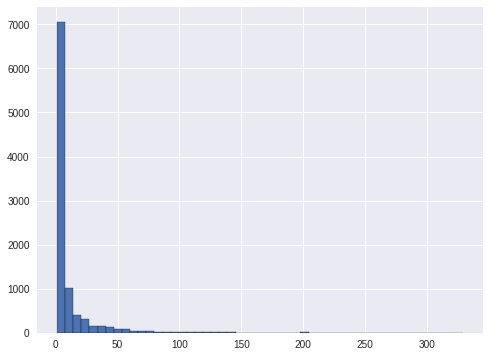

In [0]:



#  1) No of people who rated the top 100 ratings that is , rating counts of top 100 movies.....histogram
movie_data = pd.merge(ratings, movies, on='movieId',how = 'inner')

#movie_data.groupby('movieId')['rating'].mean().head()
#movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head(100)
ratings_mean_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())
ratings_mean_count.head()

plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
ratings_mean_count['rating_counts'].hist(bins=50)  



#movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head()
#ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())
#print(ratings_mean_count.head())

In [0]:
#  2)  Histogram for average ratings
plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True 
plt.xlabel('Average Ratings')
plt.ylabel('No. of average ratings')
ratings_mean_count['rating'].hist(bins=50) 



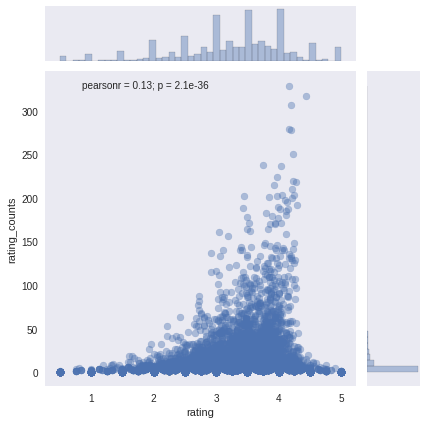

In [0]:
#  3) ratings_counts vs ratings

plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4) 


In [0]:
##  

user_movie_rating = movie_data.pivot_table(index='userId', columns='title', values='rating')

#print(user_movie_rating)
forrest_gump_ratings = user_movie_rating['Forrest Gump (1994)'] 

movies_like_forest_gump = user_movie_rating.corrwith(forrest_gump_ratings)

corr_forrest_gump = pd.DataFrame(movies_like_forest_gump, columns=['Correlation'])  
corr_forrest_gump.dropna(inplace=True)  
corr_forrest_gump.head()

corr_forrest_gump.sort_values('Correlation', ascending=False).head(10) 

corr_forrest_gump = corr_forrest_gump.join(ratings_mean_count['rating_counts'])  
corr_forrest_gump.sort_values('Correlation', ascending=False).head(10) 

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


,Correlation,rating_counts
title,,
Lost & Found (1999),1.0,2
"Century of the Self, The (2002)",1.0,2
The 5th Wave (2016),1.0,2
Play Time (a.k.a. Playtime) (1967),1.0,3
Memories (Memorîzu) (1995),1.0,3
Playing God (1997),1.0,3
Killers (2010),1.0,2
"Girl Walks Home Alone at Night, A (2014)",1.0,2
Tampopo (1985),1.0,3


In [0]:
corr_forrest_gump[corr_forrest_gump ['rating_counts']>50].sort_values('Correlation', ascending=False).head()

,Correlation,rating_counts
title,,
Forrest Gump (1994),1.000000,329
Mr. Holland's Opus (1995),0.652144,80
Pocahontas (1995),0.550118,68
Grumpier Old Men (1995),0.534682,52
Caddyshack (1980),0.520328,52
